# Lab Assignment 2 - Part C: Naive Bayes for Spam Detection
Please refer to the `README.pdf` for full laboratory instructions.


## Problem Statement
In this part, you will implement a **Naive Bayes classifier** for spam email detection using the Spambase dataset.

### Dataset Description
The Spambase dataset contains 4601 email samples with 57 features:
- **Features 1-48**: Word frequencies (percentage of words matching specific words)
- **Features 49-54**: Character frequencies (`;`, `(`, `[`, `!`, `$`, `#`)
- **Features 55-57**: Capital letter statistics
- **Label**: 1 = spam, 0 = not spam

### Your Tasks
1. **Implement Gaussian Naive Bayes** from scratch
2. **Train and evaluate** your classifier (accuracy, precision, recall, F1-score)
3. **Feature analysis**: Identify top discriminative features
4. **Discussion**: Why does Naive Bayes work for spam detection?


## Setup


In [1]:
%pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library declarations
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo


## Load the Spambase Dataset


In [3]:
# Fetch Spambase dataset from UCI ML Repository
spambase = fetch_ucirepo(id=94)

# Get features and labels
X = spambase.data.features.values
y = spambase.data.targets.values.ravel()

print(f"Dataset shape: {X.shape}")
print(f"Number of spam emails: {np.sum(y == 1)}")
print(f"Number of non-spam emails: {np.sum(y == 0)}")
print(f"\nFeature names: {list(spambase.data.features.columns[:10])}...")  # First 10 features


Dataset shape: (4601, 57)
Number of spam emails: 1813
Number of non-spam emails: 2788

Feature names: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail']...


In [4]:
# Split data into training (80%) and testing (20%) sets
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    np.random.seed(random_state)
    n_samples = len(y)
    indices = np.random.permutation(n_samples)
    test_size = int(n_samples * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 3681 samples
Testing set: 920 samples


## Task 1: Implement Gaussian Naive Bayes
Implement a Gaussian Naive Bayes classifier from scratch.

**Key formulas:**
- Class prior: $P(C) = \frac{N_C}{N}$
- Gaussian likelihood: $P(x_i|C) = \frac{1}{\sqrt{2\pi\sigma_{i,C}^2}} \exp\left(-\frac{(x_i - \mu_{i,C})^2}{2\sigma_{i,C}^2}\right)$
- Use **log-probabilities** to avoid numerical underflow!


In [5]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier implementation.
    """
    
    def __init__(self):
        self.classes = None
        self.priors = None      # P(C) for each class
        self.means = None       # Mean of each feature per class
        self.variances = None   # Variance of each feature per class
    
    def fit(self, X, y):
        """
        Train the Naive Bayes classifier.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        y : numpy array of shape (n_samples,)
        """
        # TODO: Implement training
        # 1. Get unique classes
        # 2. Calculate class priors P(C)
        # 3. Calculate mean and variance for each feature per class
        # Hint: Add a small epsilon to variance to avoid division by zero
        
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)

        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.priors = np.zeros(n_classes, dtype=float)
        self.means = np.zeros((n_classes, n_features), dtype=float)
        self.variances = np.zeros((n_classes, n_features), dtype=float)

        eps = 1e-9  # variance smoothing

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.priors[idx] = X_c.shape[0] / X.shape[0]
            self.means[idx] = X_c.mean(axis=0)
            self.variances[idx] = X_c.var(axis=0) + eps

        return self
    
    def _gaussian_log_likelihood(self, x, mean, var):
        """
        Calculate log of Gaussian probability density.
        
        Returns:
        --------
        log_likelihood : float
        """
        # TODO: Implement log of Gaussian PDF
        # log P(x|C) = -0.5 * log(2*pi*var) - 0.5 * (x - mean)^2 / var
        x = np.asarray(x, dtype=float)
        mean = np.asarray(mean, dtype=float)
        var = np.asarray(var, dtype=float)

        ll = -0.5 * np.sum(np.log(2.0 * np.pi * var) + ((x - mean) ** 2) / var)
        return float(ll)
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
        
        Returns:
        --------
        predictions : numpy array of shape (n_samples,)
        """
        # TODO: Implement prediction
        # For each sample:
        #   1. Calculate log P(C) + sum of log P(x_i|C) for each class
        #   2. Return the class with highest log probability
        X = np.asarray(X, dtype=float)
        log_priors = np.log(self.priors)

        preds = []
        for x in X:
            log_posts = []
            for k in range(len(self.classes)):
                ll = self._gaussian_log_likelihood(x, self.means[k], self.variances[k])
                log_posts.append(log_priors[k] + ll)
            preds.append(self.classes[int(np.argmax(log_posts))])

        return np.array(preds)
    
    def predict_proba(self, X):
        """
        Return probability estimates for samples.
        
        Returns:
        --------
        probabilities : numpy array of shape (n_samples, n_classes)
        """
        # TODO: (Optional) Implement probability estimation
        X = np.asarray(X, dtype=float)
        log_priors = np.log(self.priors)

        log_posteriors = np.zeros((X.shape[0], len(self.classes)), dtype=float)

        for i, x in enumerate(X):
            for k in range(len(self.classes)):
                ll = self._gaussian_log_likelihood(x, self.means[k], self.variances[k])
                log_posteriors[i, k] = log_priors[k] + ll

        # stable softmax
        max_log = np.max(log_posteriors, axis=1, keepdims=True)
        probs = np.exp(log_posteriors - max_log)
        probs = probs / np.sum(probs, axis=1, keepdims=True)

        return probs


## Task 2: Train and Evaluate
Train your classifier and compute evaluation metrics.


In [6]:
def compute_metrics(y_true, y_pred):
    """
    Compute classification metrics.
    
    Returns:
    --------
    accuracy, precision, recall, f1_score : floats
    """
    # TODO: Implement metrics computation
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return float(accuracy), float(precision), float(recall), float(f1_score)


def confusion_matrix(y_true, y_pred):
    """
    Create confusion matrix.
    
    Returns:
    --------
    matrix : numpy array of shape (2, 2)
        [[TN, FP], [FN, TP]]
    """
    # TODO: Implement confusion matrix
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))

    return np.array([[tn, fp], [fn, tp]], dtype=int)


## Task 3: Feature Analysis
Identify the most discriminative features for spam detection.


In [7]:
# TODO: Train your classifier
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)

# TODO: Make predictions
y_pred = nb_classifier.predict(X_test)

# TODO: Compute and print metrics
accuracy, precision, recall, f1 = compute_metrics(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# TODO: Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)


Accuracy: 0.8217
Precision: 0.7233
Recall: 0.9385
F1-Score: 0.8170

Confusion Matrix:
[[390 140]
 [ 24 366]]


In [11]:
# TODO: Identify top 5 most discriminative features
# Hint: You can measure discriminative power by:
# - Difference in means between classes (normalized by pooled std)
# - Or by feature importance based on model weights

feature_names = list(spambase.data.features.columns)

# TODO: Calculate discriminative score for each feature
X0 = X_train[y_train == 0]
X1 = X_train[y_train == 1]
discriminative_scores = []
for i in range(X.shape[1]):
    # Calculate how different the feature distributions are for spam vs non-spam
    m0 = X0[:, i].mean()
    m1 = X1[:, i].mean()
    v0 = X0[:, i].var()
    v1 = X1[:, i].var()
    pooled_std = np.sqrt(0.5 * (v0 + v1) + 1e-12)
    score = abs(m1 - m0) / pooled_std
    discriminative_scores.append(score)

# TODO: Get top 5 features
discriminative_scores = np.array(discriminative_scores)
top_5_indices = np.argsort(discriminative_scores)[::-1][:5]
print("Top 5 most discriminative features:")
for idx in top_5_indices:
    print(f"  {feature_names[idx]}: score = {discriminative_scores[idx]:.6f}")


Top 5 most discriminative features:
  word_freq_your: score = 0.830701
  word_freq_remove: score = 0.665662
  word_freq_000: score = 0.654416
  char_freq_$: score = 0.624474
  word_freq_you: score = 0.600231


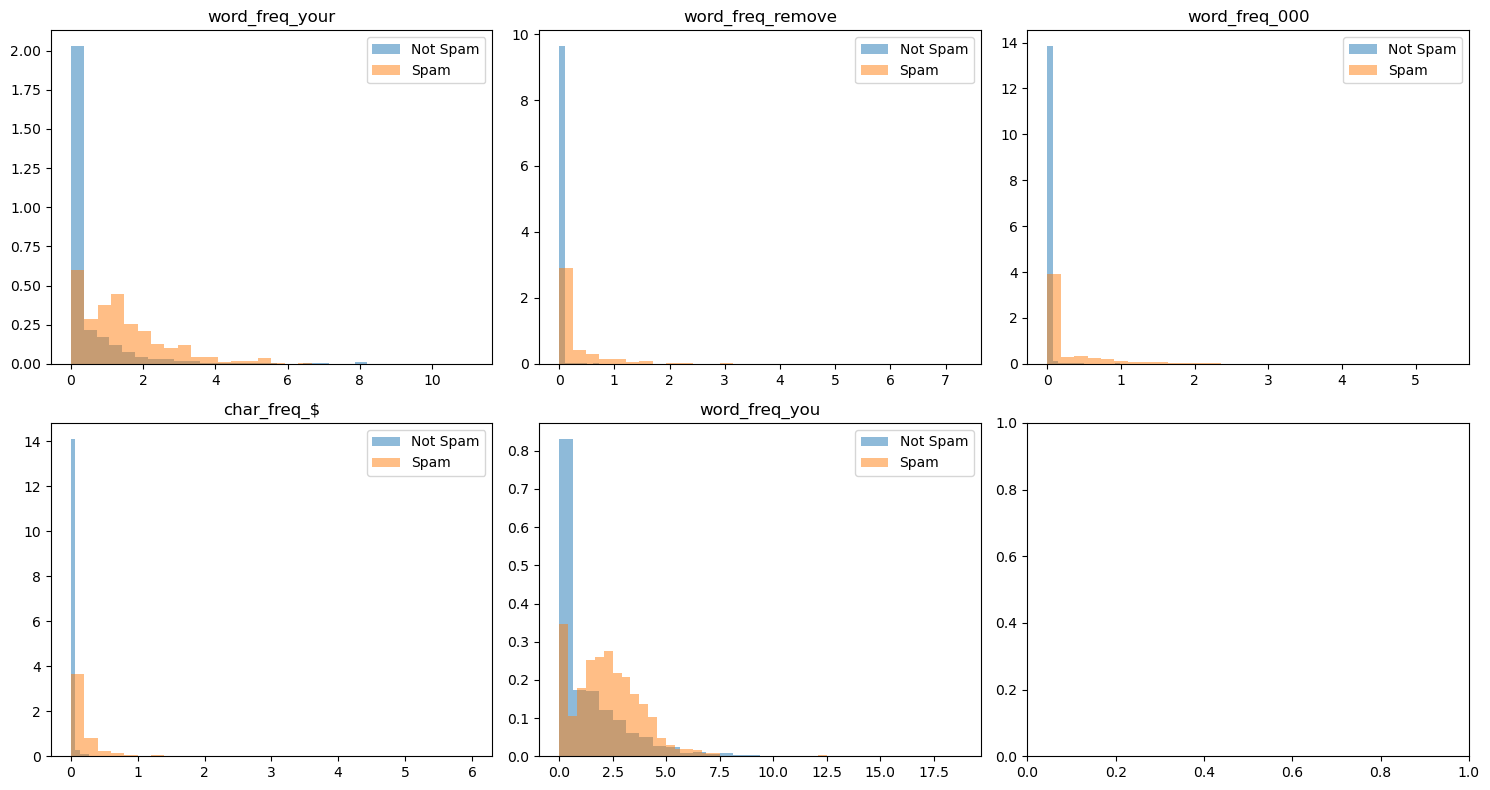

In [13]:
# TODO: Visualize distributions of top features for spam vs non-spam
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, idx in enumerate(top_5_indices[:5]):
    ax = axes[i // 3, i % 3]
    ax.hist(X[y == 0, idx], bins=30, alpha=0.5, label='Not Spam', density=True)
    ax.hist(X[y == 1, idx], bins=30, alpha=0.5, label='Spam', density=True)
    ax.set_title(f'{feature_names[idx]}')
    ax.legend()
plt.tight_layout()
plt.show()


## Summary and Discussion

### Results Table
| Metric | Value |
|--------|-------|
| Accuracy | 0.8217 |
| Precision | 0.7233 |
| Recall | 0.9385 |
| F1-Score | 0.8170 |

### Top 5 Discriminative Features
1. word_freq_your
2. word_freq_remove
3. word_freq_000
4. char_freq_$
5. word_freq_you


### Discussion
*Answer these questions:*
1. Why is Naive Bayes effective for spam detection despite the independence assumption?

    Naive Bayes performs well for spam detection because spam emails often contain strong individual indicators, such as specific words, symbols, or capitalization patterns. Even though the independence assumption is not strictly true, Naive Bayes can still achieve good performance as long as these features are conditionally informative. 

2. What are the limitations of your implementation?

    One limitation is the independence assumption, which ignores correlations between features. In real emails, words and characters are often correlated.Additionally, this implementation assumes that all features follow a Gaussian distribution, which may not perfectly match the true distribution of word frequencies.

3. How could you improve the classifier?

    Using feature selection to remove weak or redundant features. 
    
    Applying cross-validation to obtain more reliable performance estimates. 
    
    Exploring other variants of Naive Bayes, such as multinomial Naive Bayes, which may better model word frequency data. 
    
    Combining Naive Bayes with more expressive models, such as logistic regression or ensemble methods

4. What did you learn from this exercise?

    This exercise helped me understand how Naive Bayes works in practice and why it is effective for text-based classification problems like spam detection. Implementing the algorithm reinforced my understanding of probability modeling, log-likelihood computation, and evaluation metrics.

